https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.upsample

In [0]:
feat = self.backbone(X)
up = F.upsample(feat, size=(args['h_size'], args['h_size']), mode='bilinear')
out = self.clas(up)

In [0]:
# Basic imports.
import os
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import transforms
from torchvision import datasets
from torchvision import models

from skimage import io
from skimage import transform

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'n_classes': 3, #19,      # Number of classes in segmentation task.
    'pretrained': True,   # Boolean indicating pretraining of backbone.
    'skip': True,         # Boolean indicating presence of Skip Connections.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 8,      # Mini-batch size.
    'w_size': 224,        # Width size for image resizing.
    'h_size': 224,        # Height size for image resizing.
    'show_freq': 5,      # Show predictions in images each show_freq epochs.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Métricas usadas para Segmentação Semântica

As métricas mais utilizadas na área de segmentação semântica (e em algumas aplicações em terefas de detecção também) são variações da Intersection over Union ($IoU$), também chamada de **Jaccard**.

![IoU](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png/300px-Intersection_over_Union_-_poor%2C_good_and_excellent_score.png)

Em tarefas de segmentação/detecção binária, se usa a $IoU$ simples, dada pela fórmula:

$IoU = \frac{\|A\ \cap\ B\|}{\|A\ \cup\ B\|} = \frac{TP}{TP + FP + FN}$.

No caso de problemas multiclasse, usa-se a média do $IoU$ para todas as classes, chamada de mean Intersection over Union ($mIoU$).

A métrica F1 (conhecida também como **Dice**) também é utilizada nesses contextos e é dada pela fórmula:

$F1 = \frac{2TP}{2TP + FP + FN}$.

In [0]:
# Computing mean Intersection over Union (mIoU).
def evaluate(prds, labs):
    
    int_sum = np.zeros(args['n_classes'], dtype=np.float32)
    uni_sum = np.zeros(args['n_classes'], dtype=np.float32)
    
    for prd, lab in zip(prds, labs):
        
        for c in range(args['n_classes']):

            union = np.sum(lab.ravel() == c)
            if union > 0:
                uni_sum[c] += union
                
                intersection = np.sum(np.logical_and(lab.ravel() == c, prd.ravel() == c))
                int_sum[c] += intersection
    
    return int_sum, uni_sum

# O dataset Pascal VOC 2012

O dataset da competição [Pascal VOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) contém rótulos para detecção e segmentação de imagens, como pode ser visto nas imagens abaixo. Ele e o dataset [COCO](http://cocodataset.org/) são os principais benchmarks da área de Visão Computacional atualmente em tarefas de segmentação semântica e detecção em imagens.

![](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21.jpg)![](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21_class.png)

O Pytorch recentemente lançou um dataloader específico pro Pascal VOC 2012.

In [0]:
# Root directory for VOC.
root = './'

# Classes left in Pascal VOC 2012.
voc_classes = [0, 89, 147]

# All classes in Pascal VOC 2012.
# voc_classes = [0, 14, 19, 33, 37, 38, 52, 57, 72, 75, 89, 94, 108, 112, 113, 128, 132, 147, 150, 220]

# Custom Image Transform.
class VOCImgTransform(object):
    
    def __call__(self, img):
#         img = transforms.functional.five_crop(img, (args['h_size'], args['w_size']))
        img = transforms.functional.center_crop(img, (args['h_size'], args['w_size']))
        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img,
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        
#         print('img', img.size(), img.type())
        
        return img

# Custom Target Transform.
class VOCTarTransform(object):
    
    def to_sequential_labels(self, tar):
        
        for i, c in enumerate(voc_classes):
            tar[tar == c] = i
        
        tar[tar > 2] = 0
        return tar
    
    def __call__(self, tar):
        tar = tar.convert(mode='I')
        tar = transforms.functional.center_crop(tar, (args['h_size'], args['w_size']))
        tar = transforms.functional.to_tensor(tar).squeeze().type(torch.int64)
        
        tar = self.to_sequential_labels(tar)
        
        return tar


# Setting datasets.
download_voc = not os.path.isdir('./VOCdevkit/')
train_set = datasets.VOCSegmentation(root,
                                     image_set='train',
                                     download=download_voc,
                                     transform=VOCImgTransform(),
                                     target_transform=VOCTarTransform())
val_set = datasets.VOCSegmentation(root,
                                   image_set='val',
                                   download=False,
                                   transform=VOCImgTransform(),
                                   target_transform=VOCTarTransform())

Exibindo algumas imagens do Pascal VOC 2012 e seus respectivos rótulos a nível de pixel.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


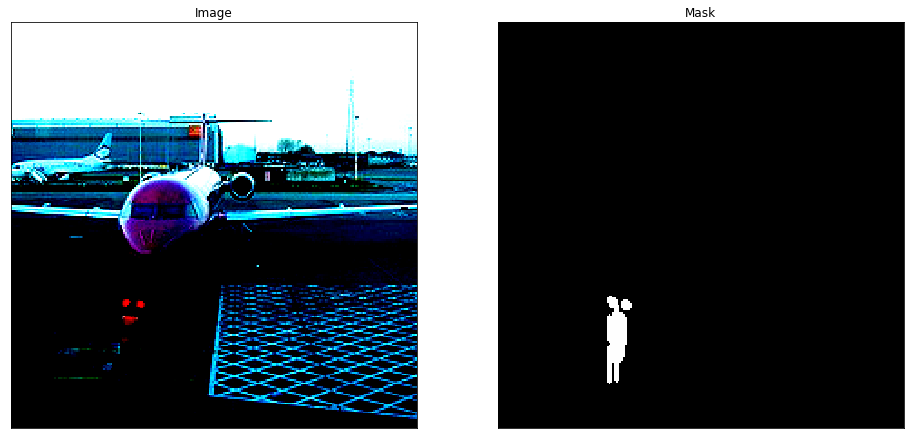

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


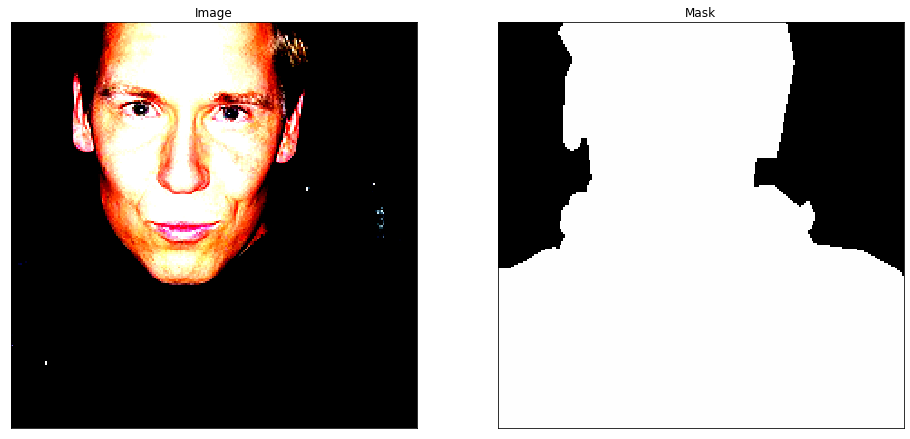

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


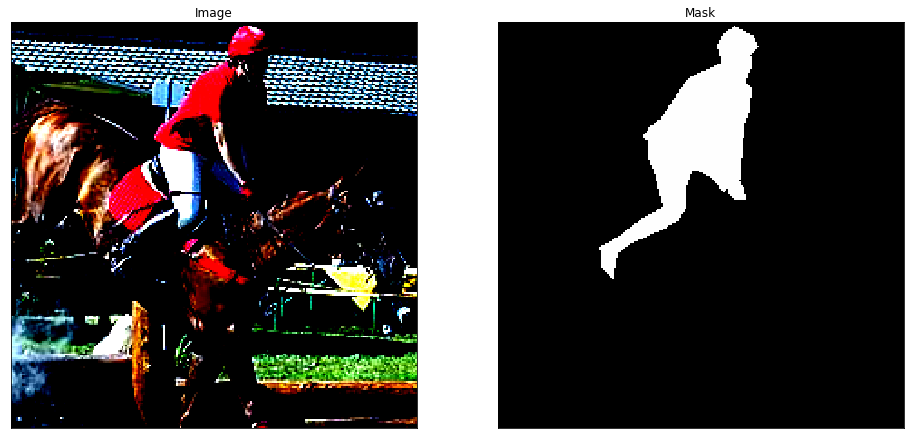

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


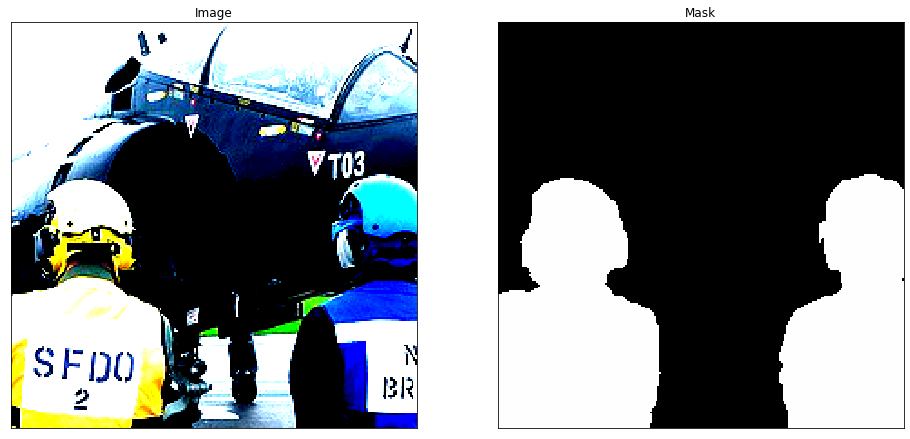

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


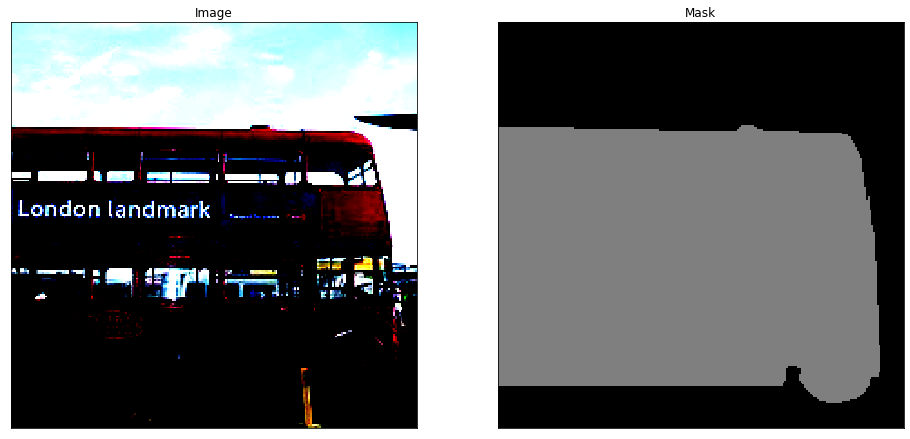

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


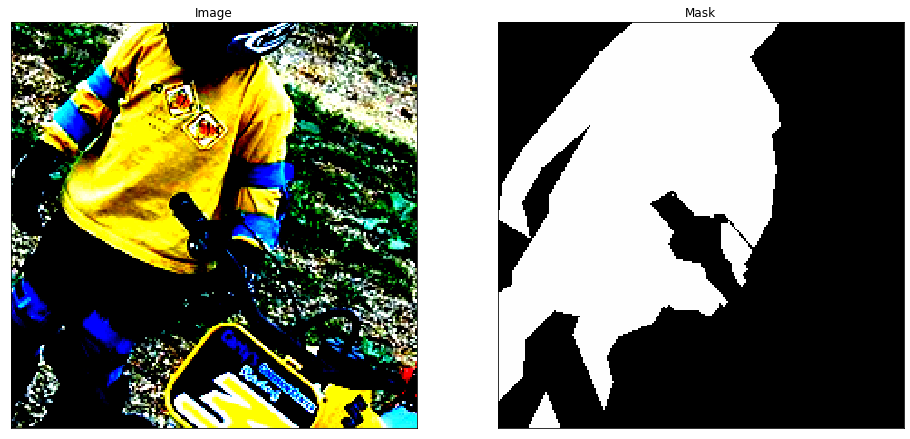

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


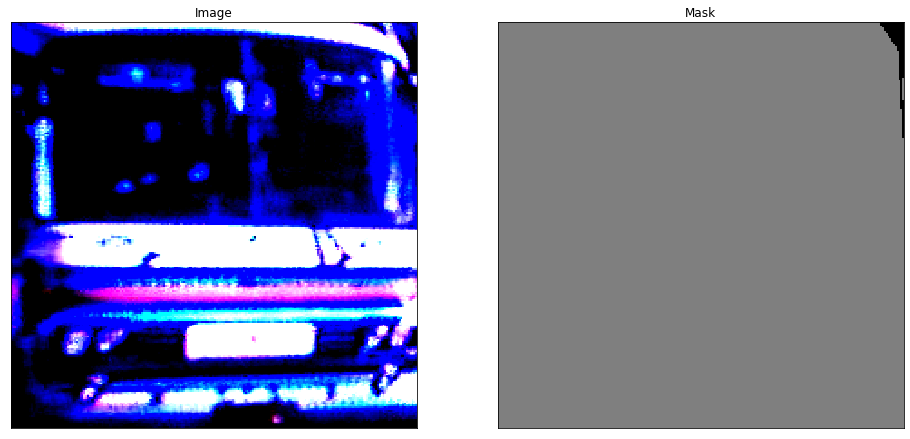

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


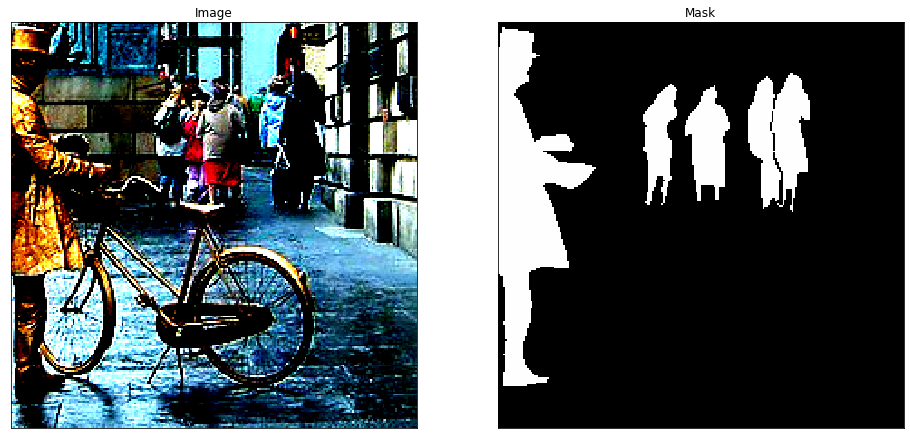

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


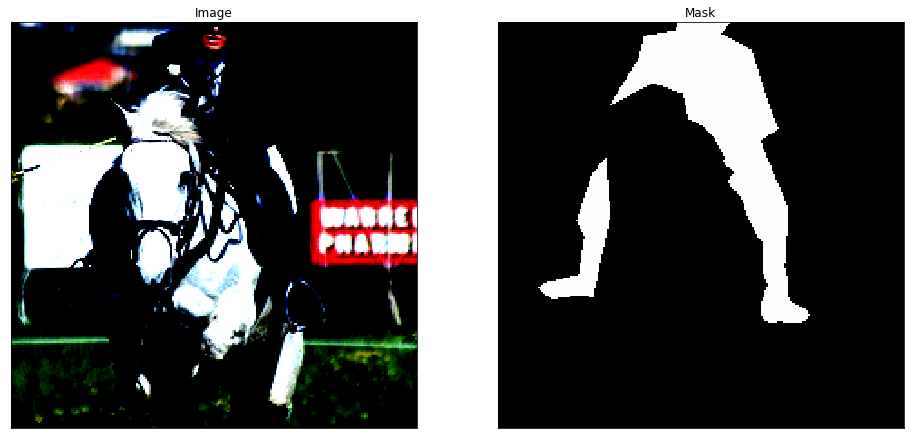

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


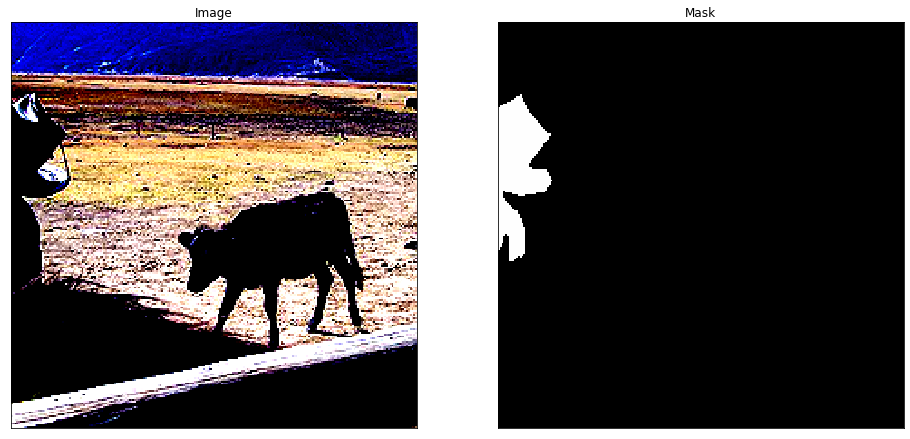

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


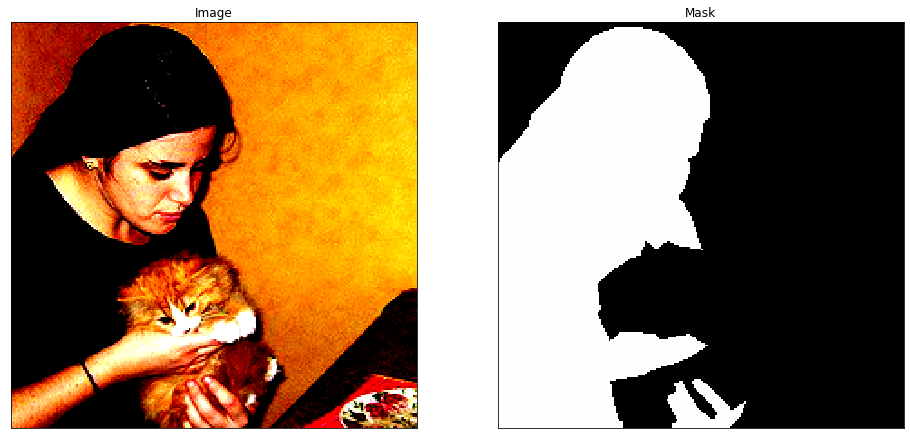

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


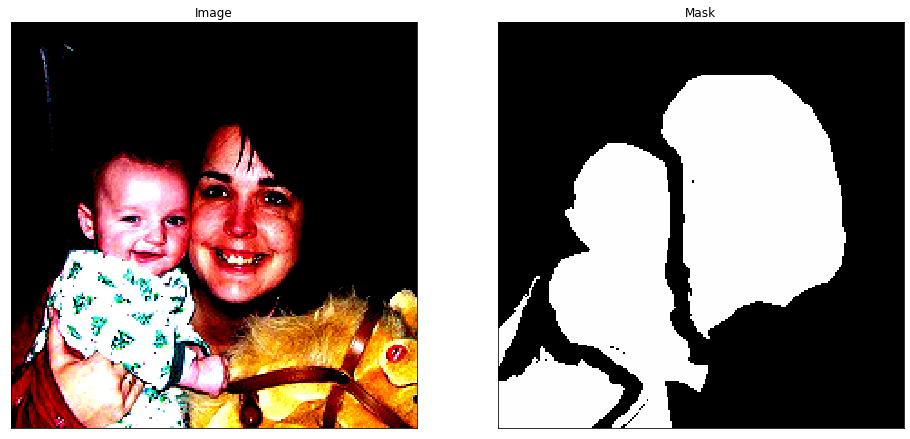

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


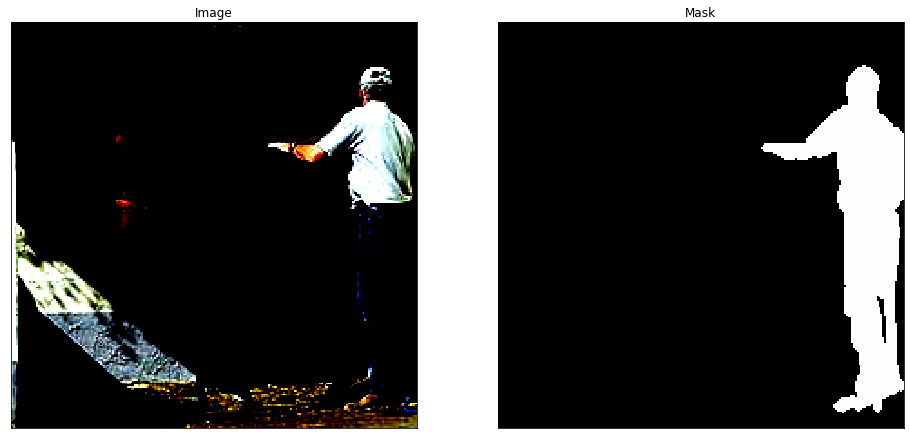

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


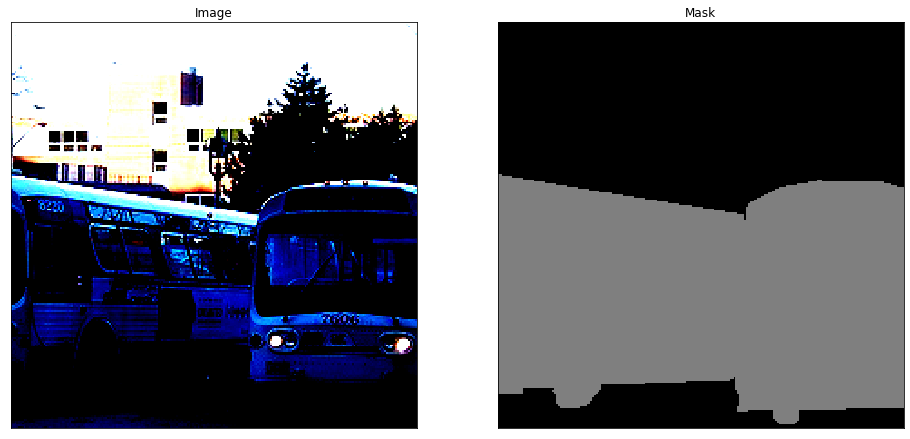

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


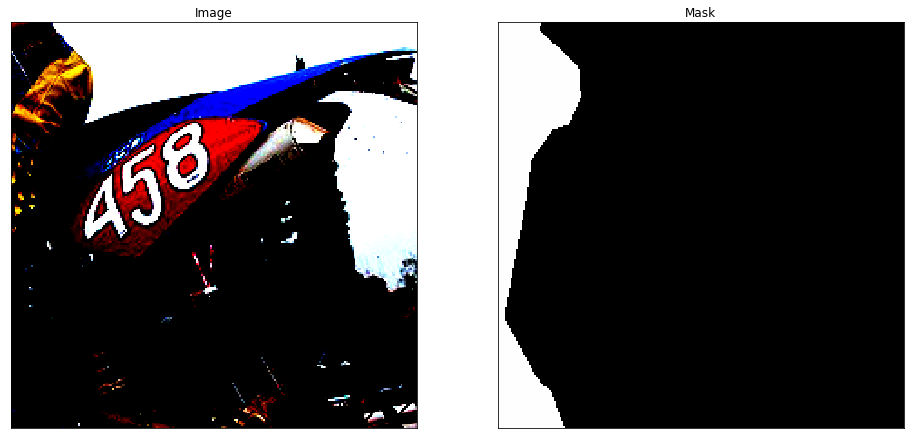

1464 440
1449 439


In [0]:
# Filtering VOC dataset to iterate only over samples from predefined classes.
train_indices = []
val_indices = []

valid_classes = [0, 1, 2]
    
for i, batch_data in enumerate(train_set):
    
    imgs, labs = batch_data
    
    curr_labels = set(list(labs.numpy().ravel()))
    
    if len([c for c in valid_classes if c in curr_labels]) >= 2: 
    
        train_indices.append(i)
        
        if i < 50:
            
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
            ax[0].imshow(imgs.numpy().transpose(1, 2, 0))
            ax[0].set_yticks([])
            ax[0].set_xticks([])
            ax[0].set_title('Image')

            ax[1].imshow(labs.numpy().squeeze() * 127, cmap=plt.get_cmap('gray'),
                         vmin=0, vmax=255)
            ax[1].set_yticks([])
            ax[1].set_xticks([])
            ax[1].set_title('Mask')

            plt.show()
            
for i, batch_data in enumerate(val_set):
    
    imgs, labs = batch_data
    
    curr_labels = set(list(labs.numpy().ravel()))
    
    if len([c for c in valid_classes if c in curr_labels]) >= 2:
    
        val_indices.append(i)

print(len(train_set), len(train_indices))
print(len(val_set), len(val_indices))

Definindo dataloader customizado baseado no subsample do dataset padrão Pascal VOC 2012.

In [0]:
# Sampler for limiting classes to humans and automobiles.
sampler_train = data.SubsetRandomSampler(train_indices)
sampler_val = data.SubsetRandomSampler(val_indices)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          num_workers=args['num_workers'],
                          sampler=sampler_train)
val_loader = DataLoader(val_set,
                        batch_size=1,
                        num_workers=args['num_workers'],
                        sampler=sampler_val)

# Atividade Prática

Implemente uma FCN com o backbone de uma VGG16 **pré-treinada** completando o código abaixo. 
> Use a VGG16 com batch normalization: https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16_bn

### Na função `__init__()`

* O `backbone` deve incluir apenas as camadas de `features` da VGG16. Caso necessário, imprima a arquitetura da VGG16 para entender melhor essa instrução.

* Acrescente uma sequência de camadas (`classifier`) para classificar as features extraídas pelo backbone.
    *Sugestão: 1 bloco convolucional composto por convolução, batch normalization, ativação ReLU e Dropout + 1 convolução final.

### Na função `forward()`

* Realize o forward no backbone 

* Realize um **upsample bilinear** para recuperar a resolução original da imagem.

* Forward nas camadas de classificação.

In [0]:
class FCN_VGG16(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(FCN_VGG16, self).__init__()

        self.backbone = models.vgg16_bn(pretrained=pretrained, progress=False).features

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):

        feat = self.backbone(x)
        feat = F.upsample(feat, x.size()[2:], mode='bilinear')
        output = self.classifier(feat)

        return output
        
net = FCN_VGG16(args['n_classes'],
                pretrained=args['pretrained']).to(args['device'])

print(net)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


FCN_VGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

## Optimizer

**Vamos fazer um fine-tuning diferente!**

Defina diferentes taxas de aprendizado para os parâmetros de sua rede. <br>
Documentação (Per-parameter options): https://pytorch.org/docs/stable/optim.html

* Para o backbone (VGG16) defina $10\%$ da taxa de aprendizado definida em `args['lr']`
* Para a sequência de classificação, defina `args['lr']` como taxa de aprendizado.
* Por fim, defina os últimos hiperparâmetros
```python
weight_decay=args['weight_decay'],
betas=(args['momentum'], 0.999)
```

In [0]:
optimizer = optim.Adam([{'params': net.backbone.parameters(), 'lr': args['lr'] * 0.1},
                        {'params': net.classifier.parameters()}],
                               lr=args['lr'],
                               weight_decay=args['weight_decay'],
                               betas=(args['momentum'], 0.999))

## Loss

Como segmentação é uma tarefa de classificação de pixels, a loss deve ser novamente a Cross Entropy. A única diferença para a tarefa de classificação da aula passada é que as dimensões espaciais dos labels $(224, 224)$ e das predições da rede $(\#classes, 224, 224)$ devem ser linearizadas para o cálculo da loss, resultado em vetores de dimensões $(224*224)$ e $(\#classes, 224*224)$. Essa linearização deve ser implementada nas funções *train()* e *test()*.

In [0]:
# Setting loss.
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.1, 1.0, 1.0])).to(args['device'])

## Training & Validation

In [0]:
# Training function.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    int_all = np.asarray(args['n_classes'], dtype=np.float32)
    uni_all = np.asarray(args['n_classes'], dtype=np.float32)

    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # TO DO: Forwarding through network.
        outs = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs.view(outs.size(0), outs.size(1), -1),
                         labs.view(labs.size(0), -1))

        # Computing backpropagation.
        loss.backward()
        optimizer.step()

        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()
        
        # Appending metrics for epoch error calculation.
        int_sum, uni_sum = evaluate([prds],
                                    [labs.detach().squeeze(0).cpu().numpy()])

        int_all = int_all + int_sum
        uni_all = uni_all + uni_sum

        # Updating loss meter.
        train_loss.append(loss.data.item())

    toc = time.time()
    
    # Transforming list into numpy array.
    train_loss = np.asarray(train_loss)
    
    # Computing error metrics for whole epoch.
    iou = 0
    iou = np.divide(int_all, uni_all)
#     print(iou)

    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [miou %.4f], [time %.4f]' % (
        epoch, train_loss.mean(), train_loss.std(), iou[1:].mean(), (toc - tic)))
    print('-------------------------------------------------------------------')

def validate(val_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    val_loss = []

    int_all = np.asarray(args['n_classes'], dtype=np.float32)
    uni_all = np.asarray(args['n_classes'], dtype=np.float32)

    # Iterating over batches.
    for i, batch_data in enumerate(val_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # TO DO: Forwarding through network.
        outs = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs.view(outs.size(0), outs.size(1), -1),
                         labs.view(labs.size(0), -1))

        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()

        # Appending metrics for epoch error calculation.
        int_sum, uni_sum = evaluate([prds],
                                    [labs.detach().squeeze(0).cpu().numpy()])

        int_all = int_all + int_sum
        uni_all = uni_all + uni_sum

        # Updating loss meter.
        val_loss.append(loss.data.item())
        
        if i == 0 and epoch % args['show_freq'] == 0:
            
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            ax[0].imshow(inps[0].detach().cpu().numpy().transpose(1, 2, 0))
            ax[0].set_yticks([])
            ax[0].set_xticks([])
            ax[0].set_title('Image')
            
            ax[1].imshow(prds * 127,
                         cmap=plt.get_cmap('gray'),
                         vmin=0, vmax=255)
            ax[1].set_yticks([])
            ax[1].set_xticks([])
            ax[1].set_title('Prediction')
            
            ax[2].imshow(labs[0].detach().squeeze(0).cpu().numpy() * 127,
                         cmap=plt.get_cmap('gray'),
                         vmin=0, vmax=255)
            ax[2].set_yticks([])
            ax[2].set_xticks([])
            ax[2].set_title('True Label')
            
            plt.show()

    toc = time.time()
    
    # Transforming list into numpy array.
    val_loss = np.asarray(val_loss)
    
    # Computing error metrics for whole epoch.
    iou = 0
    iou = np.divide(int_all, uni_all)
#     print(iou)

    # Printing test epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [miou %.4f], [time %.4f]' % (
        epoch, val_loss.mean(), val_loss.std(), iou[1:].mean(), (toc - tic)))
    print('-------------------------------------------------------------------')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


-------------------------------------------------------------------
[epoch 1], [train loss 0.6376 +/- 0.2196], [miou 0.8637], [time 47.3387]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 1], [test loss 0.5225 +/- 0.3446], [miou 0.9699], [time 7.3416]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.4255 +/- 0.1014], [miou 0.9317], [time 44.3221]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [test loss 0.4298 +/- 0.2827], [miou 0.9596], [time 6.9387]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train loss 0.3605 +/- 0.0937], [miou 0.9458], [time 44.7926]
---------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


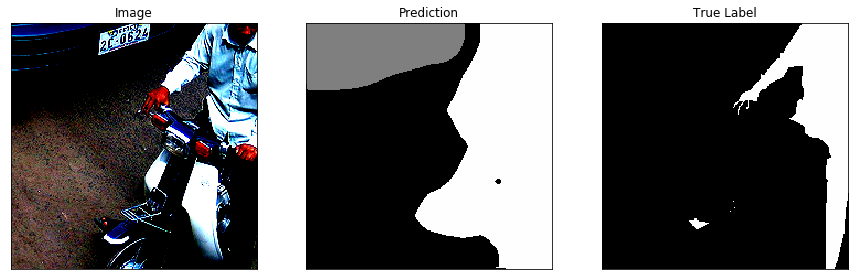

-------------------------------------------------------------------
[epoch 5], [test loss 0.3237 +/- 0.2184], [miou 0.9429], [time 7.3492]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train loss 0.2599 +/- 0.0817], [miou 0.9705], [time 45.2862]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [test loss 0.3093 +/- 0.2135], [miou 0.9436], [time 6.9527]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train loss 0.2532 +/- 0.0893], [miou 0.9625], [time 45.1844]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [test loss 0.3005 +/- 0.2061], [miou 0.9381], [time 7.0197]
-----------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


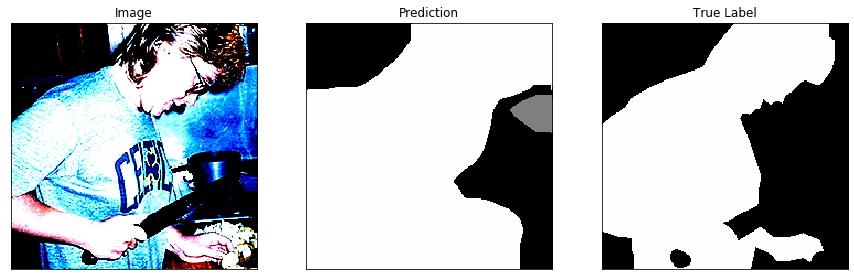

-------------------------------------------------------------------
[epoch 10], [test loss 0.2945 +/- 0.2168], [miou 0.9166], [time 7.5641]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [train loss 0.1803 +/- 0.0544], [miou 0.9758], [time 45.1410]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [test loss 0.2879 +/- 0.2184], [miou 0.9134], [time 7.2120]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [train loss 0.1802 +/- 0.0614], [miou 0.9777], [time 45.1692]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [test loss 0.2862 +/- 0.2286], [miou 0.9129], [time 6.9683]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


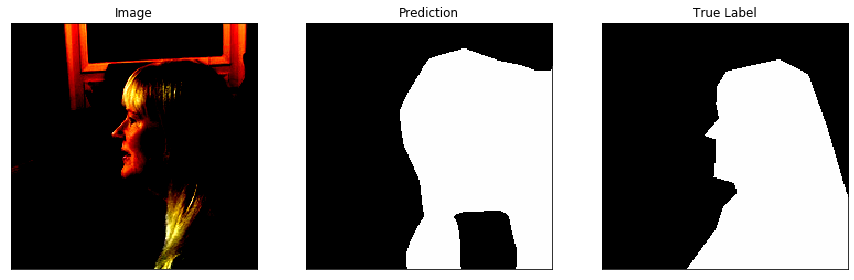

-------------------------------------------------------------------
[epoch 15], [test loss 0.3060 +/- 0.2635], [miou 0.8903], [time 7.1636]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [train loss 0.1440 +/- 0.0439], [miou 0.9824], [time 45.1428]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [test loss 0.2931 +/- 0.2566], [miou 0.8913], [time 6.9067]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [train loss 0.1317 +/- 0.0404], [miou 0.9885], [time 45.1342]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [test loss 0.2999 +/- 0.2499], [miou 0.9020], [time 7.0140]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


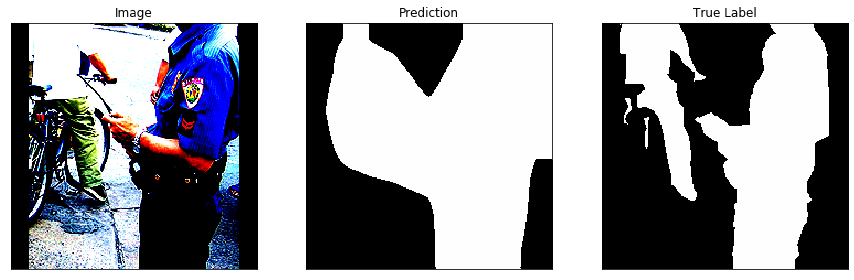

-------------------------------------------------------------------
[epoch 20], [test loss 0.3048 +/- 0.2577], [miou 0.9090], [time 7.3056]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [train loss 0.1337 +/- 0.0648], [miou 0.9845], [time 45.1558]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [test loss 0.3405 +/- 0.3166], [miou 0.8716], [time 6.9238]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [train loss 0.1179 +/- 0.0399], [miou 0.9894], [time 45.1573]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [test loss 0.3086 +/- 0.2750], [miou 0.8915], [time 7.0991]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


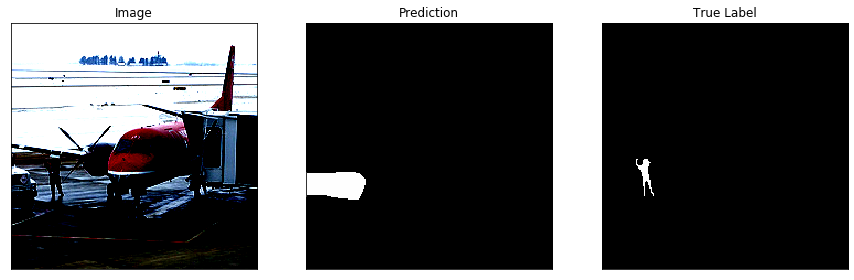

-------------------------------------------------------------------
[epoch 25], [test loss 0.3361 +/- 0.3112], [miou 0.8892], [time 7.3067]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [train loss 0.1119 +/- 0.0297], [miou 0.9906], [time 45.1300]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [test loss 0.3337 +/- 0.3075], [miou 0.8833], [time 6.9180]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [train loss 0.1158 +/- 0.0675], [miou 0.9798], [time 45.1101]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [test loss 0.3029 +/- 0.2680], [miou 0.9052], [time 6.9051]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


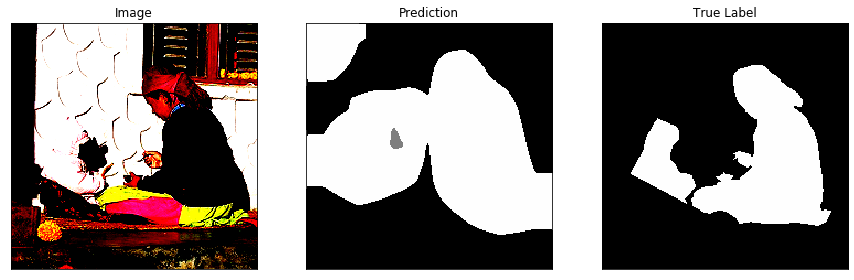

-------------------------------------------------------------------
[epoch 30], [test loss 0.3149 +/- 0.2812], [miou 0.9054], [time 7.3178]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [train loss 0.1088 +/- 0.0361], [miou 0.9893], [time 45.1117]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [test loss 0.3283 +/- 0.3010], [miou 0.8934], [time 6.8878]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [train loss 0.1099 +/- 0.0379], [miou 0.9887], [time 45.1104]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [test loss 0.3554 +/- 0.3366], [miou 0.8806], [time 7.0865]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


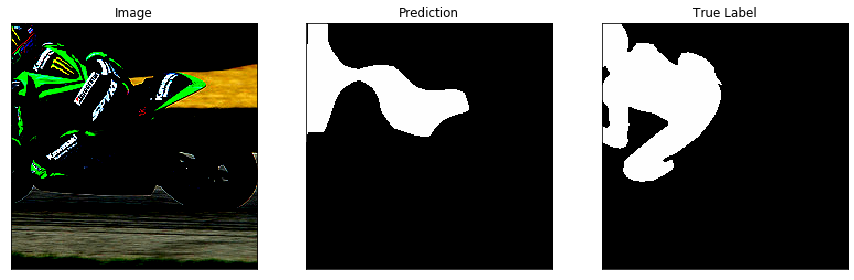

-------------------------------------------------------------------
[epoch 35], [test loss 0.3537 +/- 0.3422], [miou 0.8693], [time 7.2541]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [train loss 0.0939 +/- 0.0384], [miou 0.9927], [time 45.0710]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [test loss 0.3353 +/- 0.3168], [miou 0.8948], [time 7.0172]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [train loss 0.0908 +/- 0.0272], [miou 0.9924], [time 45.0647]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [test loss 0.3216 +/- 0.3042], [miou 0.8868], [time 6.9140]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


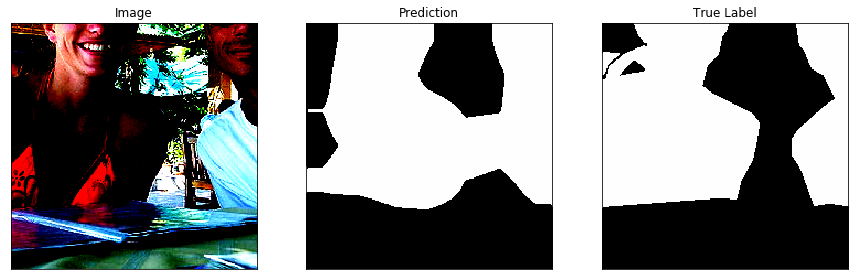

-------------------------------------------------------------------
[epoch 40], [test loss 0.3384 +/- 0.3289], [miou 0.8861], [time 7.3257]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [train loss 0.1048 +/- 0.0631], [miou 0.9838], [time 45.1714]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [test loss 0.4493 +/- 0.4629], [miou 0.8372], [time 6.9947]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [train loss 0.0997 +/- 0.0335], [miou 0.9892], [time 45.1364]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [test loss 0.3441 +/- 0.3401], [miou 0.8788], [time 7.1224]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


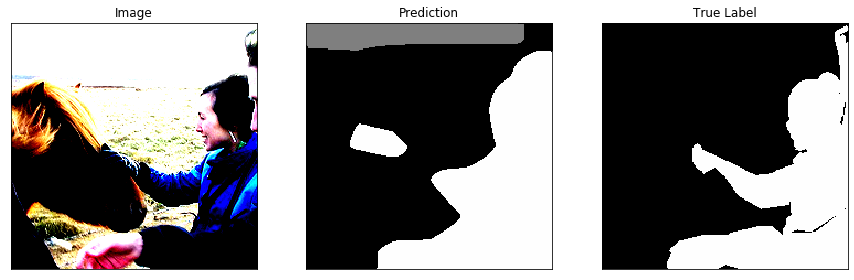

-------------------------------------------------------------------
[epoch 45], [test loss 0.3698 +/- 0.3868], [miou 0.8774], [time 7.2211]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [train loss 0.0905 +/- 0.0340], [miou 0.9918], [time 45.0071]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [test loss 0.3399 +/- 0.3318], [miou 0.9026], [time 6.8862]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [train loss 0.0925 +/- 0.0400], [miou 0.9882], [time 45.0749]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [test loss 0.3740 +/- 0.4005], [miou 0.8673], [time 7.0429]
------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


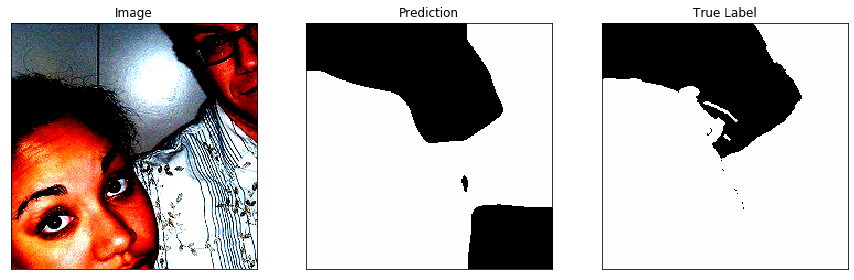

-------------------------------------------------------------------
[epoch 50], [test loss 0.3665 +/- 0.3683], [miou 0.8811], [time 7.0951]
-------------------------------------------------------------------


In [0]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    validate(val_loader, net, criterion, epoch)